# Apply PCM to 3D gridded products

Apply PCM method to __3D gridded products__ defined as inputs in BlueCloud project:
- GLOBAL-ANALYSIS-FORECAST-PHY-001-024
- GLOBAL_REANALYSIS_PHY_001_030
- GLOBAL_REANALYSIS_PHY_001_031
- GLOBAL_REANALYSIS_BIO_001_029

Only data in Mediterranean sea is used. NetCDF files have been downloaded from CMEMS catalogue.
Notebook developped in __local__

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

## User input
***

__Choose dataset__

In [ ]:
# try CORA dataset
# file_path = '/home5/pharos/REFERENCE_DATA/OCEAN_REP/CORA/CORA5.1/field/2016/*_TEMP.nc'
# lon_extent = [120,165]
# lat_extent = [22,55]
# temp_var = 'TEMP'
# ds = xr.open_mfdataset(file_path,combine='by_coords', concat_dim=time_dim)
# ds

In [ ]:
# ds = ds.sel(latitude=slice(lat_extent[0],lat_extent[1]), longitude=slice(lon_extent[0], lon_extent[1])) 
# ds

In [ ]:
#file_path = '/home5/pharos/REFERENCE_DATA/OCEAN_REP/SODA/assim/SODA_2.2.4/SODA_2.2.4_200801.cdf'
#lon_dim = 'lon'
#lat_dim = 'lat'
#z_dim = 'depth'
#temp_var = 'temp'

In [2]:
#### file path ####

# GLOBAL-ANALYSIS-FORECAST-PHY-001-024
#file_path = '/export/home1/agarciaj/datasets/global-analysis-forecast-phy-001-024_1598520725098.nc'

# GLOBAL_REANALYSIS_PHY_001_030
file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1600874641188_caribe.nc'
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601630960671_safrica.nc'
# mediterranean
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-030-monthly_1601036810235.nc'

# GLOBAL_REANALYSIS_PHY_001_031
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-phy-001-031-grepv2-monthly_1598972586332.nc'

# GLOBAL_REANALYSIS_BIO_001_029
#file_path = '/export/home1/agarciaj/datasets/global-reanalysis-bio-001-029-monthly_1598524945308.nc'


# time and coordinates dimensions (expecify then here but use a generic name in the rest of the notebook)
time_dim = 'time'
lon_dim = 'longitude'
lat_dim = 'latitude'
z_dim = 'depth'
temp_var = 'thetao'

#temp_var = 'fe'

__Model options__

In [3]:
#Choise of z and pcm features (very important to make a good choise) 
z = np.arange(-1.,-2000,-10.)
pcm_features = {'temperature': z}
#pcm_features = {'iron': z}

#classes
K=10

#fit
features_in_ds = {'temperature': temp_var}

__Plot options__

## Get data
***

Open data files

In [4]:
#open data file
ds = xr.open_dataset(file_path)
ds

<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 277, longitude: 457, time: 12)
Coordinates:
  * depth      (depth) float32 0.494025 1.541375 2.645669 ... 5274.784 5727.917
  * latitude   (latitude) float32 8.0 8.083333 8.166667 ... 30.916666 31.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -98.0 -97.916664 ... -60.083332 -60.0
Data variables:
    mlotst     (time, latitude, longitude) float32 ...
    vo         (time, depth, latitude, longitude) float32 ...
    thetao     (time, depth, latitude, longitude) float32 ...
    uo         (time, depth, latitude, longitude) float32 ...
    bottomT    (time, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
    zos        (time, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

Depth values should be negative

In [5]:
#at = ds['depth'].attrs
#ds.assign_coords(depth=-np.abs(ds['depth'].values), keep_attrs=True)
ds['depth'] = -np.abs(ds['depth'].values)
#ds['depth'].attrs.update(at) # not working

In [ ]:
# for SODA dataset
#ds['lon'] = np.mod((ds['lon'].values +180),360) - 180
#ds = ds.sortby('lon')

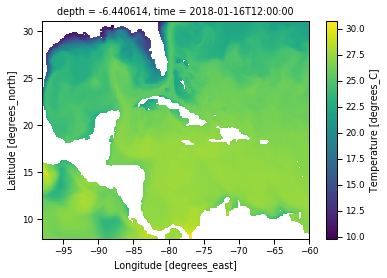

In [6]:
#ds['thetao'].isel(depth=5).plot();
ds[temp_var].isel(time=0, depth=5).plot();
#ds[temp_var].isel(depth=0).plot();
#ds['o2'].isel(time=11, depth=5).plot();
#ds['fe'].isel(time=11, depth=5).plot();

## Applying PCM
***

### Create PCM

In [7]:
#z choise
z = ds['depth'][0:20]
pcm_features = {'temperature': z}
#pcm_features = {'iron': z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 10, F: 1)>
Number of class: 10
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit Model

In [8]:
features_in_ds = {'temperature': temp_var}
#features_in_ds = {'iron': temp_var}
features_zdim=z_dim
m.fit(ds, features=features_in_ds, dim=features_zdim)
m

<pcm 'gmm' (K: 10, F: 1)>
Number of class: 10
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 45.372608

<font color=red>__TODO__</font> : save all trained PCM in a folder

In [ ]:
# save model to development
# m.to_netcdf('models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')

### Predict labels

In [9]:
features_zdim=z_dim
m.predict(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [10]:
m.predict_proba(ds, features=features_in_ds, dim=features_zdim, inplace=True);
#ds

In [11]:
ds = ds.pyxpcm.quantile(m, q=[0.05, 0.5, 0.95], of=temp_var, outname=temp_var + '_Q', keep_attrs=True, inplace=True)
#ds

/export/home1/agarciaj/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


Robustness

In [12]:
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

<xarray.Dataset>
Dimensions:             (depth: 50, latitude: 277, longitude: 457, pcm_class: 10, quantile: 3, time: 12)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3 4 5 6 7 8 9
  * depth               (depth) float32 -0.494025 -1.541375 ... -5727.917
  * latitude            (latitude) float64 8.0 8.083 8.167 ... 30.83 30.92 31.0
  * time                (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12...
  * longitude           (longitude) float64 -98.0 -97.92 -97.83 ... -60.08 -60.0
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    mlotst              (time, latitude, longitude) float32 14.038515 ... 73....
    vo                  (time, depth, latitude, longitude) float32 0.09643849...
    thetao              (time, depth, latitude, longitude) float32 26.622974 ...
    uo                  (time, depth, latitude, longitude) float32 -0.3454695...
    bottomT             (time, latitude, longitude) float32 1.5367603 ... 1.7...
    so                  (time, depth, latitude, longitude) float32 33.520004 ...
    zos                 (time, latitude, longitude) float32 0.18097477 ... 0....
    PCM_LABELS          (time, latitude, longitude) float64 7.0 7.0 ... 2.0 2.0
    PCM_POST            (pcm_class, time, latitude, longitude) float64 4.512e...
    thetao_Q            (pcm_class, quantile, depth) float64 24.12 24.09 ... nan
    PCM_ROBUSTNESS      (time, latitude, longitude) float64 0.9233 ... 1.0
    PCM_ROBUSTNESS_CAT  (time, latitude, longitude) int64 3 1 1 1 3 ... 4 4 4 4
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

In [ ]:
# save data for development
#ds.to_netcdf('models/tests_ds_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')

In [13]:
ds

<xarray.Dataset>
Dimensions:             (depth: 50, latitude: 277, longitude: 457, pcm_class: 10, quantile: 3, time: 12)
Coordinates:
  * pcm_class           (pcm_class) int64 0 1 2 3 4 5 6 7 8 9
  * depth               (depth) float32 -0.494025 -1.541375 ... -5727.917
  * latitude            (latitude) float64 8.0 8.083 8.167 ... 30.83 30.92 31.0
  * time                (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12...
  * longitude           (longitude) float64 -98.0 -97.92 -97.83 ... -60.08 -60.0
  * quantile            (quantile) float64 0.05 0.5 0.95
Data variables:
    mlotst              (time, latitude, longitude) float32 14.038515 ... 73....
    vo                  (time, depth, latitude, longitude) float32 0.09643849...
    thetao              (time, depth, latitude, longitude) float32 26.622974 ...
    uo                  (time, depth, latitude, longitude) float32 -0.3454695...
    bottomT             (time, latitude, longitude) float32 1.5367603 ... 1.7...
    so                  (time, depth, latitude, longitude) float32 33.520004 ...
    zos                 (time, latitude, longitude) float32 0.18097477 ... 0....
    PCM_LABELS          (time, latitude, longitude) float64 7.0 7.0 ... 2.0 2.0
    PCM_POST            (pcm_class, time, latitude, longitude) float64 4.512e...
    thetao_Q            (pcm_class, quantile, depth) float64 24.12 24.09 ... nan
    PCM_ROBUSTNESS      (time, latitude, longitude) float64 0.9233 ... 1.0
    PCM_ROBUSTNESS_CAT  (time, latitude, longitude) int64 3 1 1 1 3 ... 4 4 4 4
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

## Visualisation
***

In [ ]:
# for development
m = pyxpcm.load_netcdf('models/tests_model_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')
ds = xr.open_dataset('models/tests_ds_GLOBAL_REANALYSIS_PHY_001_030_temp.nc')

In [14]:
P = Plotter(ds, m)
#P = Plotter(ds, m, coords_dict={'longitude':'lon', 'latitude':'lat'})

#### 1. Vertical structure of classes

In [ ]:
#P.vertical_structure(q_variable = temp_var + '_Q', maxcols=4, figsize=(10, 12), sharey=True, xlabel)
P.vertical_structure(q_variable = temp_var + '_Q', sharey=True, xlabel='Temperature (°C)')
#P.vertical_structure(q_variable = temp_var + '_Q', maxcols=4, figsize=(10, 8), sharey=True, ylim=np.array([-2000,0]))
P.save_BlueCloud('figures/vertical_struc_EX.png')
#P.save_BlueCloud('figures/test.png')

In [ ]:
P.vertical_structure_comp(q_variable = temp_var + '_Q', plot_q= [0.05, 0.5, 0.95])
#P.save_BlueCloud('figures/vertical_struc_comp_EX.png')
P.save_BlueCloud('figures/test1.png')

#### 2. Spatial distribution of classes

In [ ]:
# TODO: when using isel hours are not good
# Input should have only one time step
P.spatial_distribution(time_slice=1)
P.save_BlueCloud('figures/spatial_distr_EX.png')

In [ ]:
P.spatial_distribution(time_slice='most_freq_label')
P.save_BlueCloud('figures/spatial_distr_freq_EX.png')

In [ ]:
# mask = ds.isel(time=7).pyxpcm.mask(m, features=features_in_ds, dim=features_zdim)
# mask.plot()

#### 3. Posteriors

In [ ]:
# Input should have only one time step
P.plot_posteriors()
P.save_BlueCloud('figures/posteriors_EX.png')

#### 4. Classes pie chart

In [ ]:
P.pie_classes()
P.save_BlueCloud('figures/pie_chart_EX.png')

#### 5. Temporal representation 

Bar plot by __month__

In [ ]:
P.temporal_distribution(time_bins = 'month')
P.save_BlueCloud('figures/temporal_distr_months_EX.png')

Bar plot by __season__

In [ ]:
P.temporal_distribution(time_bins = 'season')
P.save_BlueCloud('figures/temporal_distr_season_EX.png')

In [ ]:
#import xarray
#xarray.show_versions()

# Robustness

19.32860032241954
Figure saved in figures/test_robustness.png


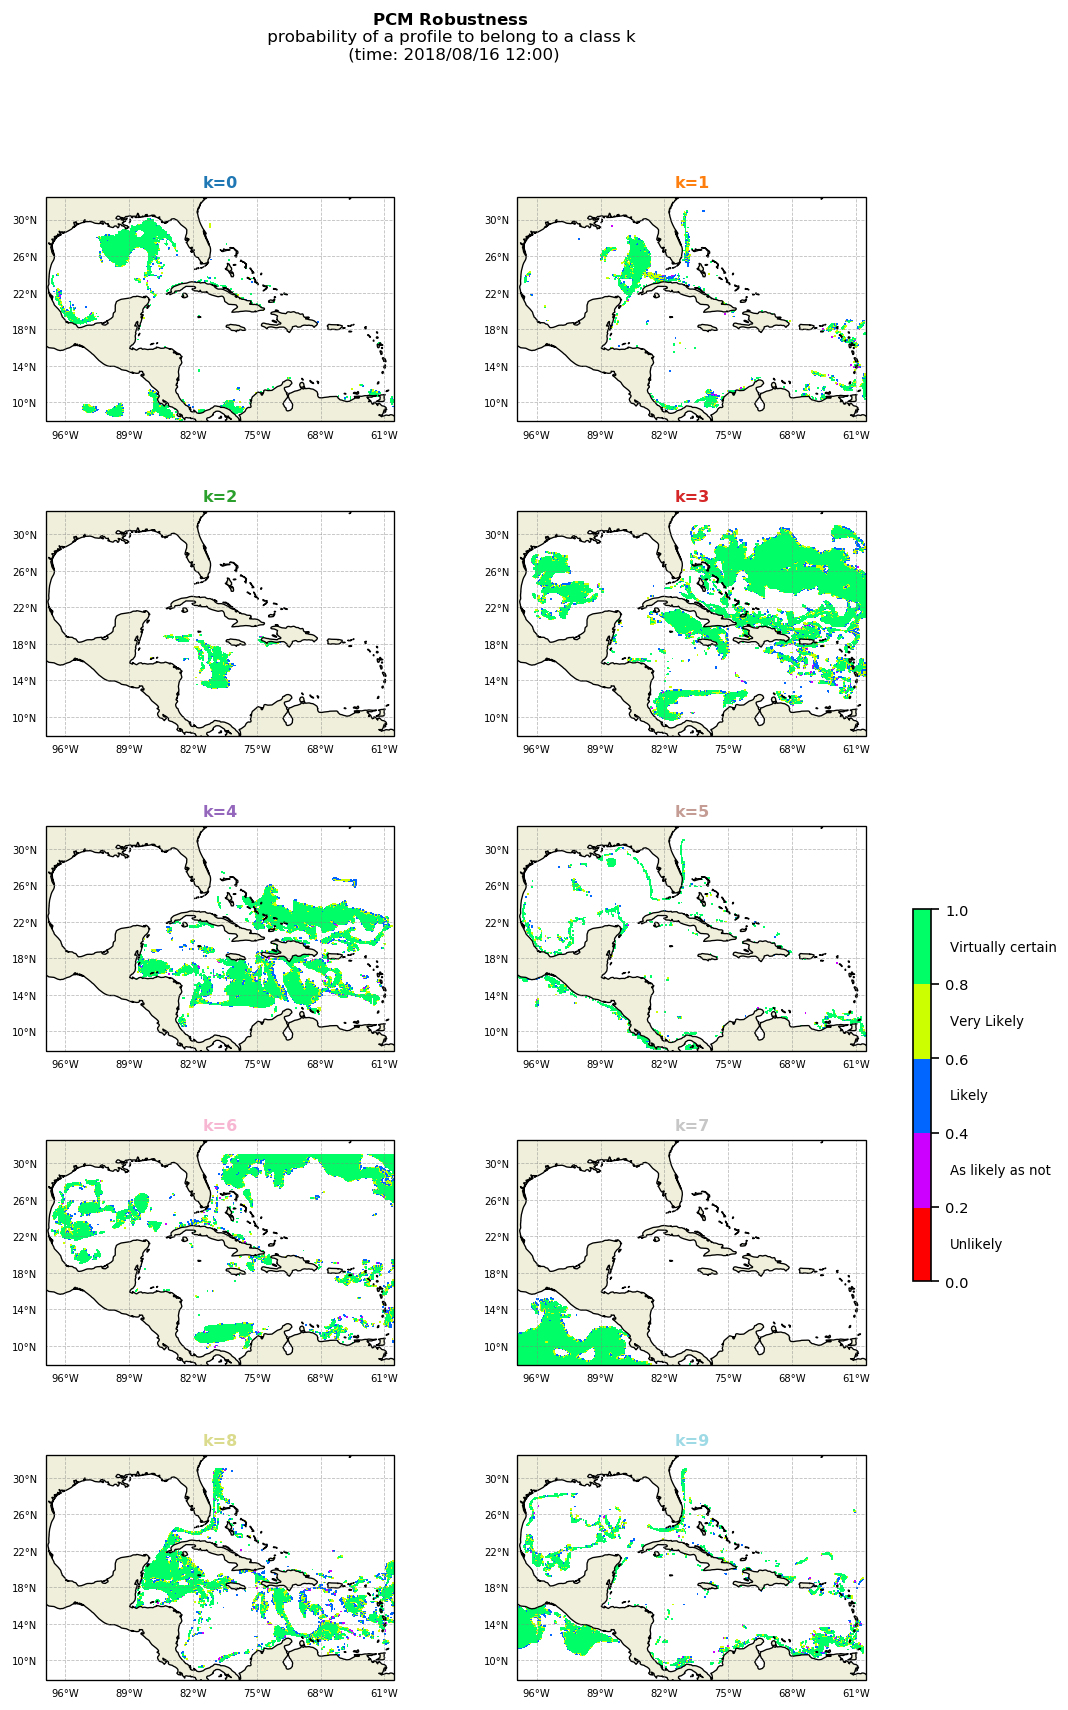

In [15]:
P.plot_robustness(time_slice=7)
P.save_BlueCloud('figures/test_robustness.png')